In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import missingno as msno
import prince
import gower
from sklearn_extra.cluster import KMedoids
import random
from sklearn.metrics import silhouette_samples, silhouette_score
from kmodes.kmodes import KModes

from sklearn.cluster import KMeans


ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [2]:
data = pd.read_csv('clean_data/partnered.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   R_age                      691 non-null    int64  
 1   P_age                      691 non-null    float64
 2   R_yrsed                    691 non-null    float64
 3   P_yrsed                    691 non-null    float64
 4   R_race                     691 non-null    object 
 5   P_race                     691 non-null    object 
 6   R_political                691 non-null    object 
 7   P_political                691 non-null    object 
 8   R_religion                 691 non-null    object 
 9   P_religion                 691 non-null    object 
 10  R_work                     691 non-null    object 
 11  R_house                    691 non-null    object 
 12  R_rent                     691 non-null    object 
 13  R_citydweller              691 non-null    object 

In [4]:
data.columns

Index(['R_age', 'P_age', 'R_yrsed', 'P_yrsed', 'R_race', 'P_race',
       'R_political', 'P_political', 'R_religion', 'P_religion', 'R_work',
       'R_house', 'R_rent', 'R_citydweller', 'R_region', 'same_sex_couple',
       'relationship_quality', 'coresident', 'relationship_length_start',
       'age_difference', 'edu_difference', 'rac_difference', 'pol_difference',
       'relig_difference', 'LGB_status', 'union_status', 'broke_up',
       'together_end'],
      dtype='object')

In [7]:
data_clustering = data[['age_difference',
                        'edu_difference',
                        'rac_difference',
                        'pol_difference',
                        'relig_difference',
                        'same_sex_couple',
                        'relationship_quality',
                        'coresident',
                        'relationship_length_start',
                        'LGB_status',
                        'union_status',
                        'broke_up']]


In [8]:
famd = prince.FAMD(n_components=2, n_iter=3,
                   copy=True, check_input=True,
                   engine='sklearn',random_state=42)

famd = famd.fit(data_clustering)
coords = famd.row_coordinates(data_clustering)

In [9]:
famd.plot(
    data,
    x_component=0,
    y_component=1
)

alt.LayerChart(...)

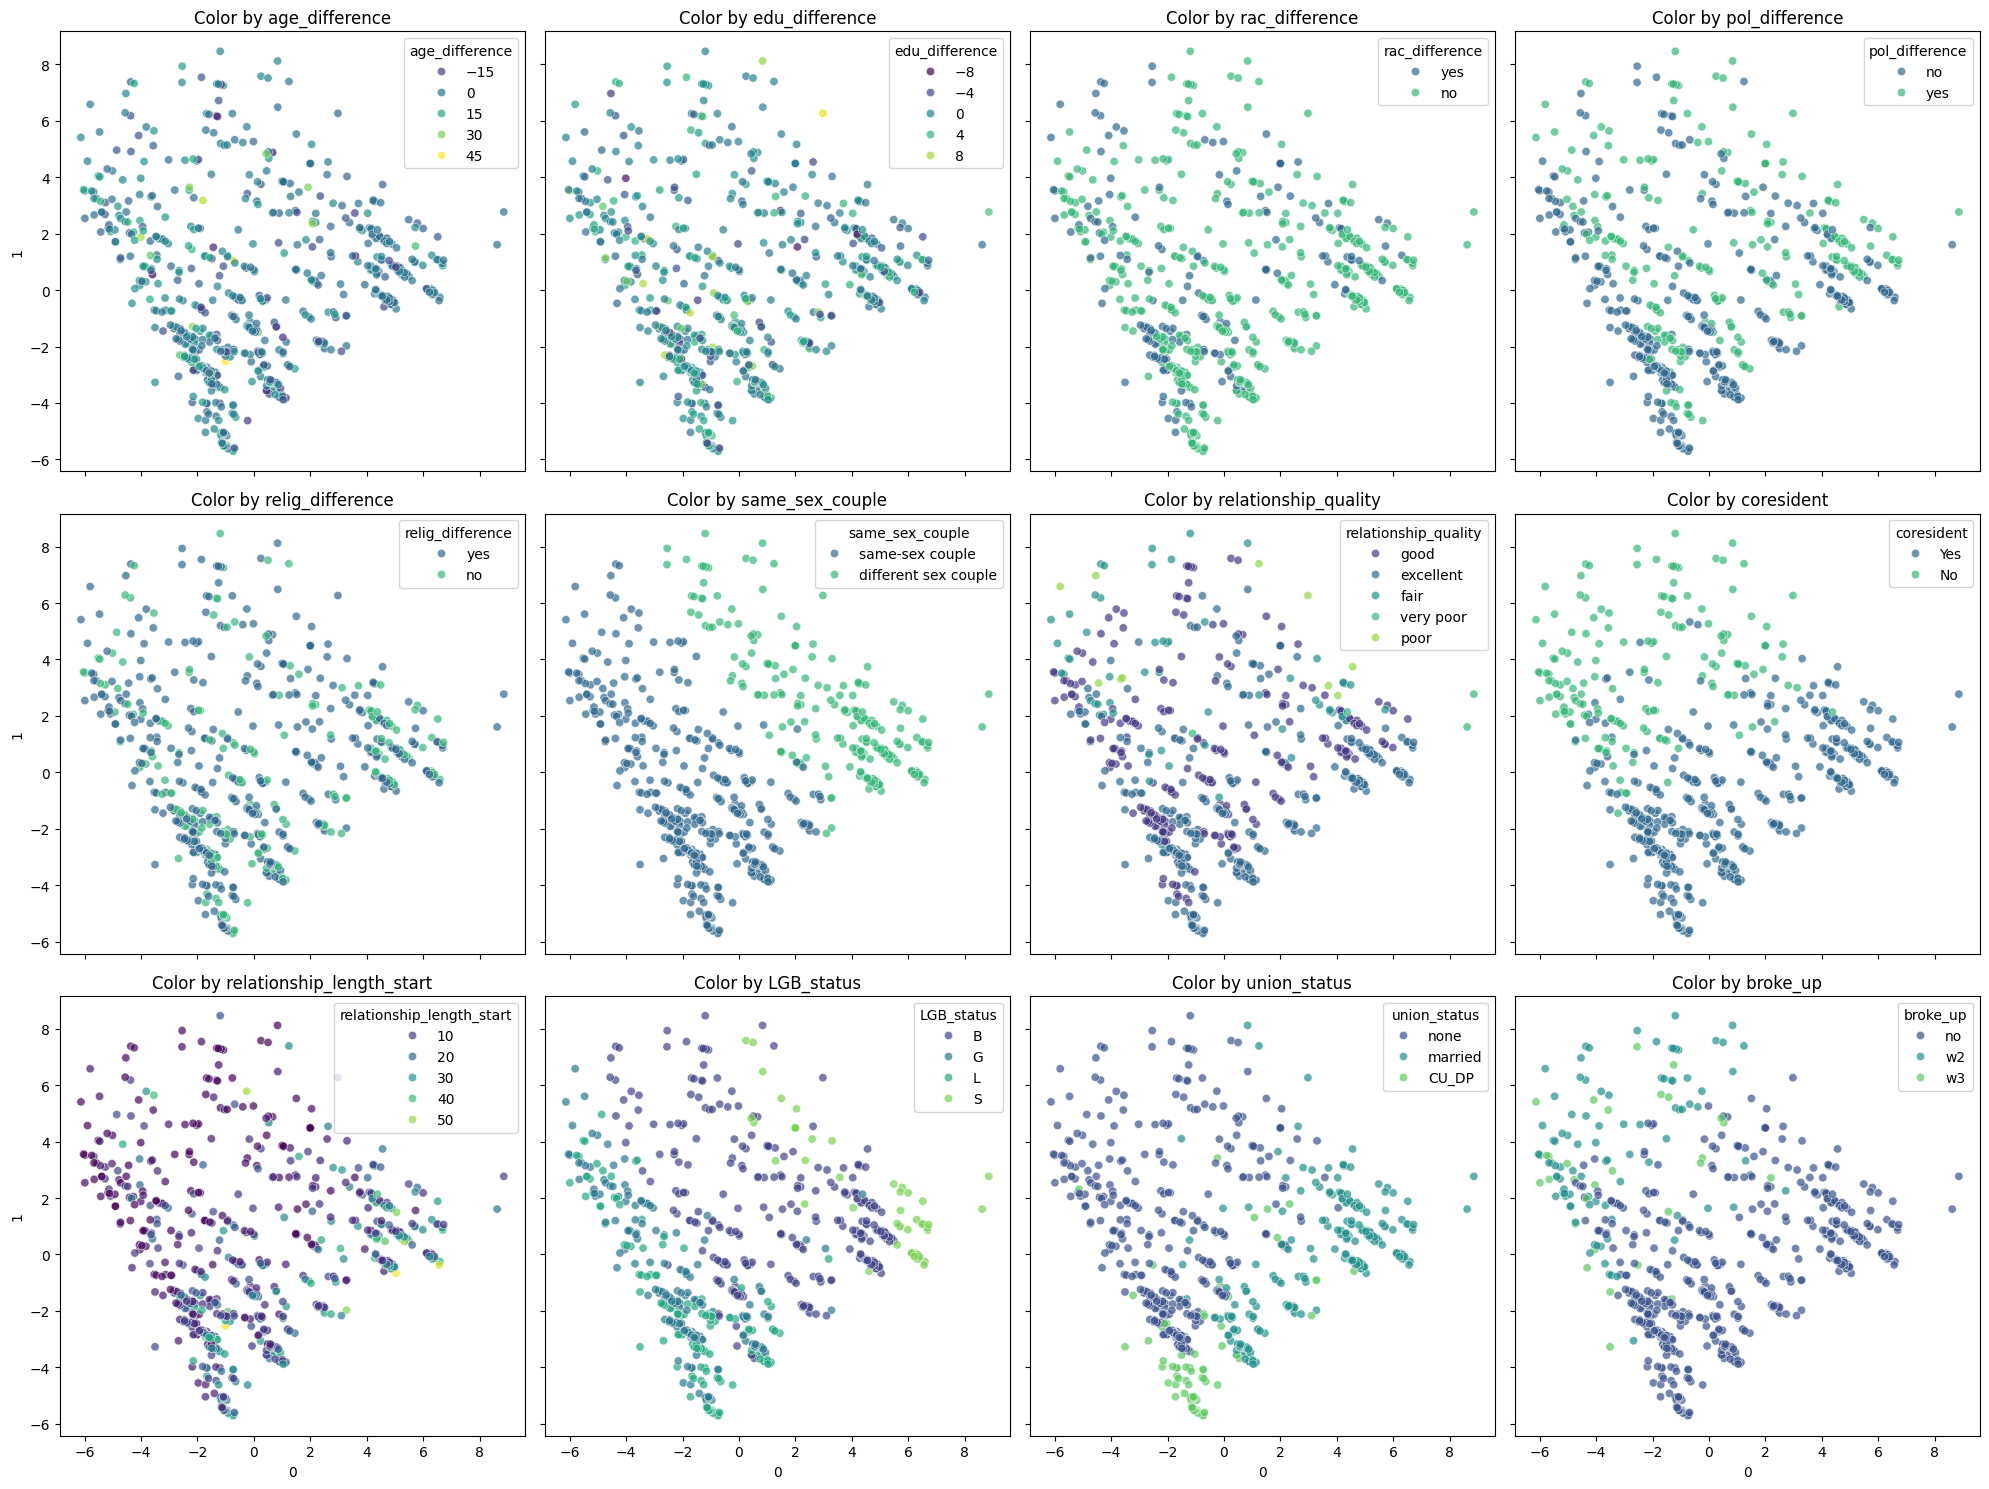

In [10]:
#Define the columns to use for coloring (excluding comp_0 and comp_1)
color_variables = [col for col in data_clustering.columns if col not in ['comp_0', 'comp_1']]

# Determine the number of rows and columns for the plot layout
num_vars = len(color_variables)
cols = 4  # Number of columns in the grid
rows = (num_vars // cols) + (num_vars % cols > 0)  # Ensure enough rows

# Set up the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten in case of multiple rows

# Create scatterplots for each variable
for ax, color_var in zip(axes, color_variables):
    sns.scatterplot(
        data=data, 
        x=coords[0], 
        y=coords[1], 
        hue=color_var, 
        palette='viridis' if data[color_var].dtype != 'category' else 'tab10', 
        alpha=0.7, 
        ax=ax
    )
    ax.set_title(f'Color by {color_var}')
    ax.legend().set_title(color_var)

# Hide any unused axes
for ax in axes[num_vars:]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

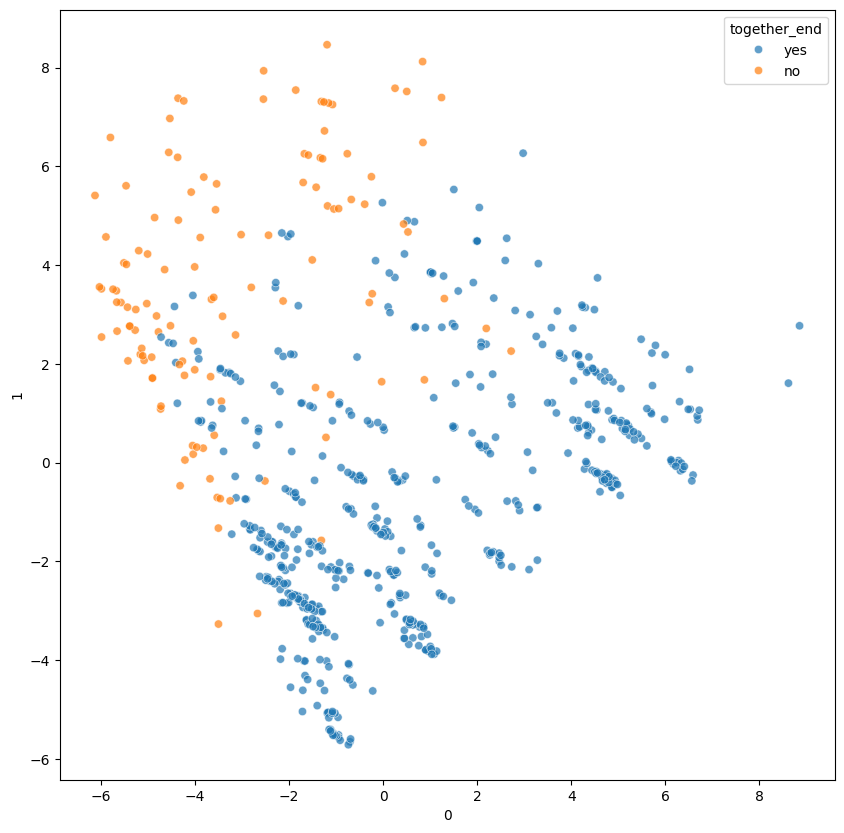

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
        data=data, 
        x=coords[0], 
        y=coords[1], 
        hue='together_end', 
        alpha=0.7, 
        ax=ax
    )

plt.show()

In [18]:

def calculate_zscore(df, columns):
  '''
  scales columns in dataframe using z-score
  '''
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

  return df


def one_hot_encode(df, columns):
  '''
  one hot encodes list of columns and
  concatenates them to the original df
  '''

  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns

  return concat_df, one_hot_cols


In [20]:
numeric_cols = data.select_dtypes(include=np.number)
cat_cols = data.select_dtypes(include='object')
  


In [29]:
# numeric process
normalized_df = calculate_zscore(data, numeric_cols)
normalized_df = normalized_df[numeric_cols.columns]

# categorical process
cat_one_hot_df, one_hot_cols = one_hot_encode(data, cat_cols)
cat_one_hot_norm_df = calculate_zscore(cat_one_hot_df, one_hot_cols)

# Merge DataFrames
processed_df = pd.concat([normalized_df, cat_one_hot_norm_df], axis=1)


clusters = (KMeans(n_clusters=2, 
                   init='k-means++', verbose=0, 
                   random_state=42,)
            .fit(processed_df)
            .labels_)

In [31]:
silhouette_score(processed_df, clusters)

np.float64(0.07744500117192382)

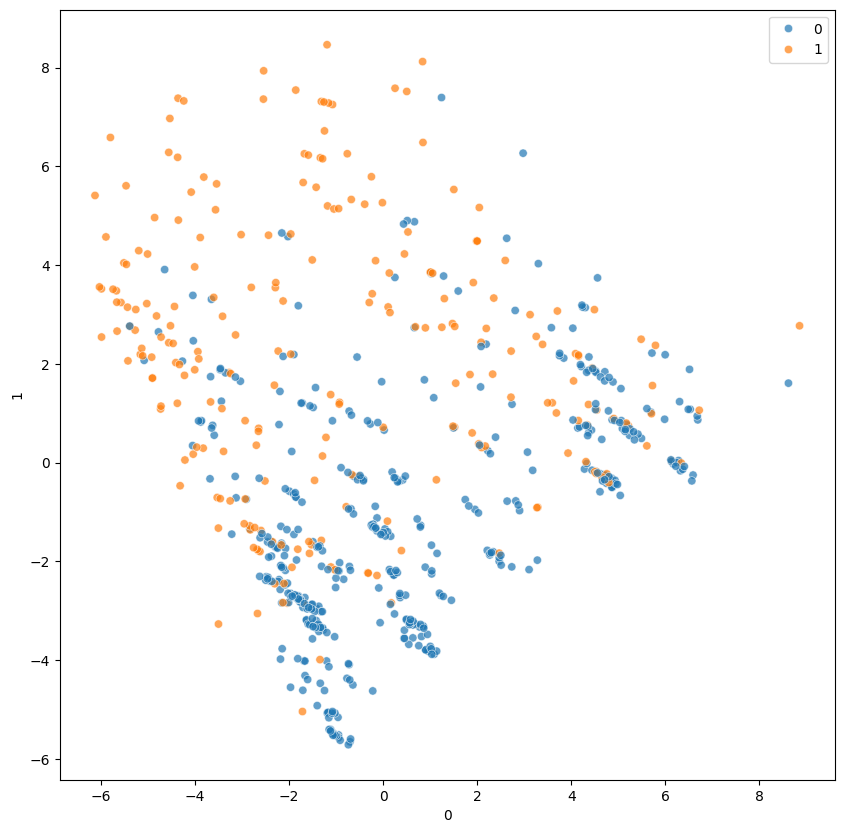

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
        data=data, 
        x=coords[0], 
        y=coords[1], 
        hue=clusters, 
        alpha=0.7, 
        ax=ax
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.07520379214303934
For n_clusters = 3 The average silhouette_score is : 0.08090610397150214
For n_clusters = 4 The average silhouette_score is : 0.027048304183918744
For n_clusters = 5 The average silhouette_score is : 0.012954837200084618
For n_clusters = 6 The average silhouette_score is : 0.018492156074175887


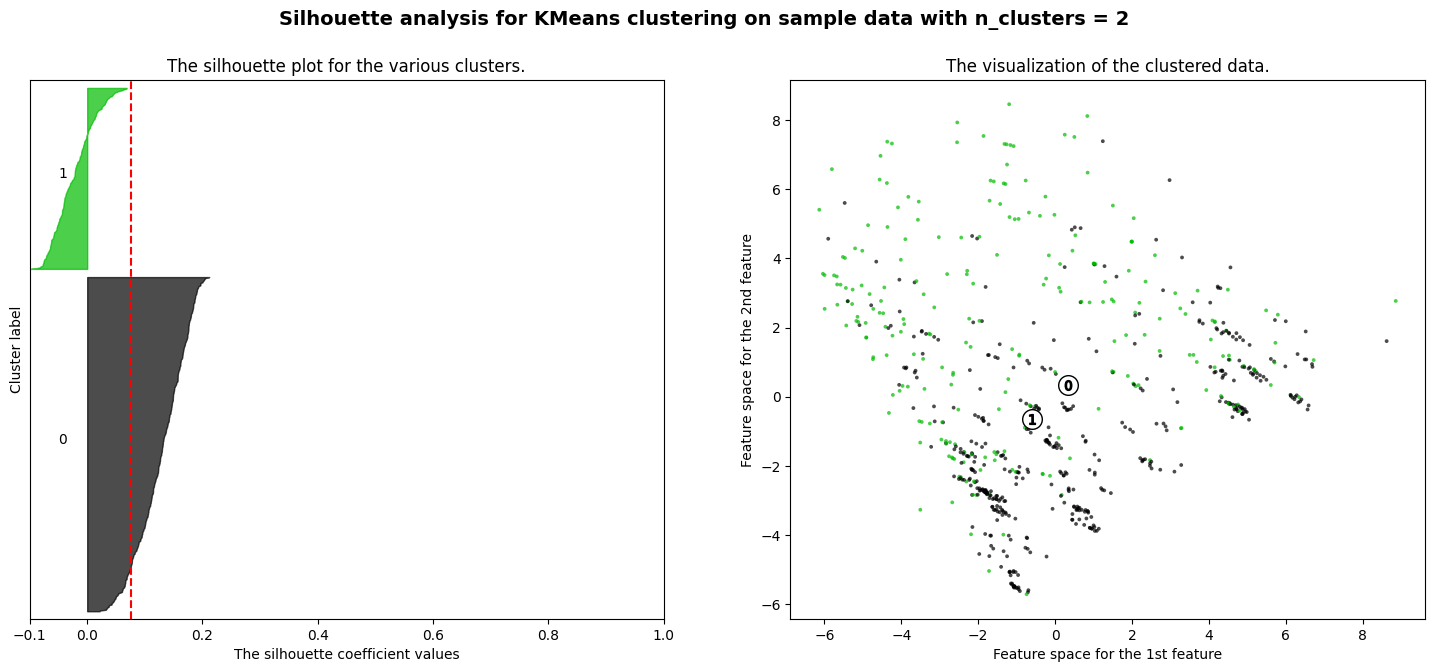

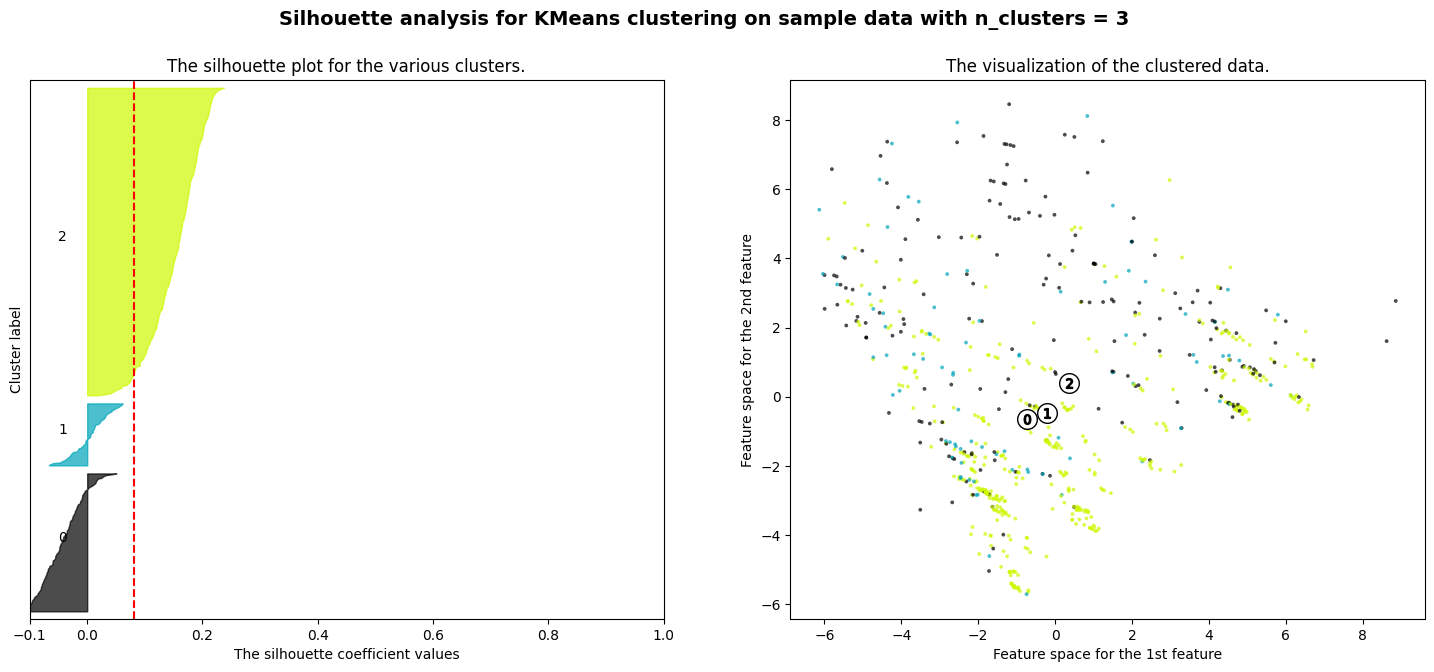

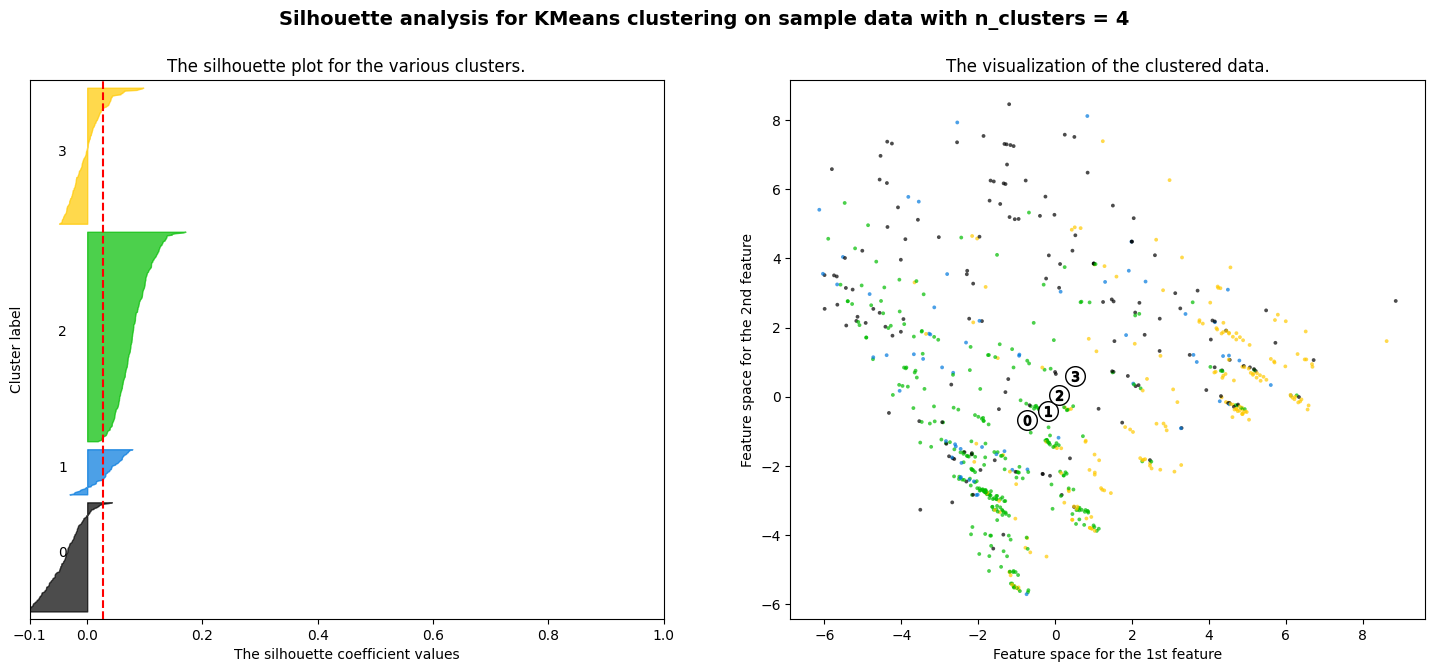

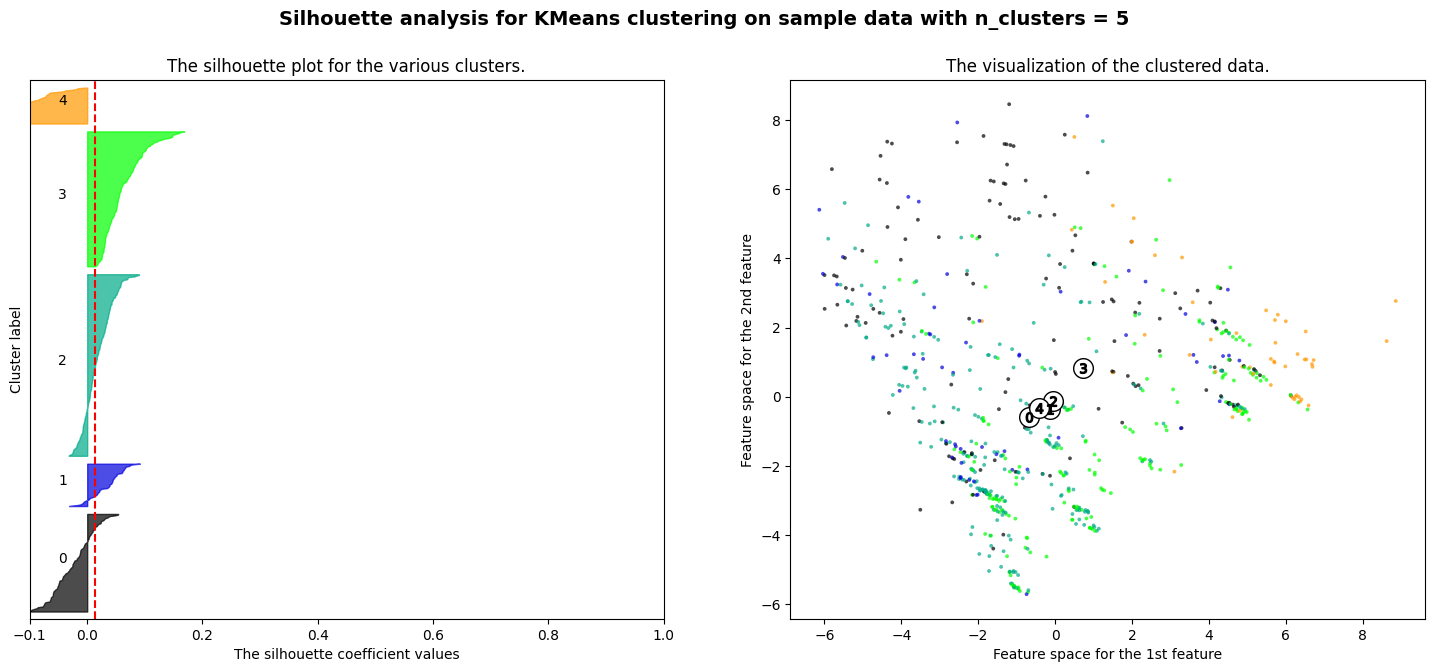

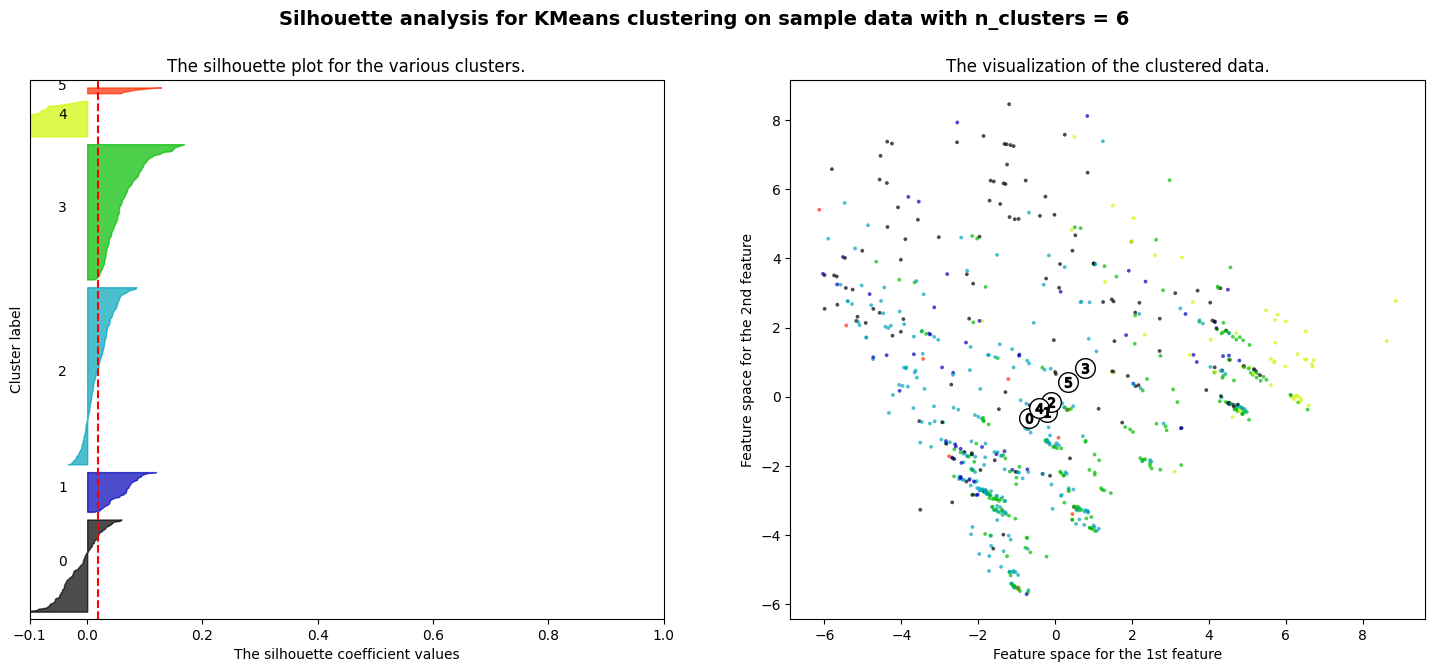

In [37]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(processed_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++')
    cluster_labels = clusterer.fit_predict(processed_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(processed_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(processed_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        coords[0], coords[1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [39]:
numeric_cols

,R_age,P_age,R_yrsed,P_yrsed,relationship_length_start,age_difference,edu_difference
0,52,48.0,16.0,14.0,7.0,4.0,2.0
1,28,30.0,17.0,16.0,8.0,-2.0,1.0
2,31,40.0,14.0,12.0,8.0,-9.0,2.0
3,53,55.0,16.0,17.0,12.0,-2.0,-1.0
4,58,51.0,17.0,17.0,30.0,7.0,0.0
...,...,...,...,...,...,...,...
686,62,49.0,13.0,14.0,11.0,13.0,-1.0
687,51,40.0,13.0,12.0,8.0,11.0,1.0
688,50,56.0,14.0,14.0,13.0,-6.0,0.0
689,24,22.0,12.0,13.0,1.5,2.0,-1.0


C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['R_age_51' 'R_age_27' 'R_age_27' 'R_age_51' 'R_age_61' 'R_age_41'
 'R_age_61' 'R_age_51' 'R_age_27' 'R_age_61' 'R_age_51' 'R_age_73'
 'R_age_27' 'R_age_51' 'R_age_41' 'R_age_51' 'R_age_73' 'R_age_41'
 'R_age_41' 'R_age_73' 'R_age_51' 'R_age_41' 'R_age_51' 'R_age_51'
 'R_age_73' 'R_age_61' 'R_age_73' 'R_age_51' 'R_age_51' 'R_age_41'
 'R_age_27' 'R_age_61' 'R_age_51' 'R_age_41' 'R_age_41' 'R_age_27'
 'R_age_73' 'R_age_27' 'R_age_73' 'R_age_51' 'R_age_51' 'R_age_73'
 'R_age_61' 'R_age_51' 'R_age_41' 'R_age_41' 'R_age_41' 'R_age_51'
 'R_age_61' 'R_age_51' 'R_age_27' 'R_age_41' 'R_age_41' 'R_age_27'
 'R_age_51' 'R_age_41' 'R_age_61' 'R_age_41' 'R_age_51' 'R_age_51'
 'R_age_51' 'R_age_51' 'R_age_41' 'R_age_73' 'R_age_51' 'R_age_51'
 'R_age_41' 'R_age_61' 'R_age_61' 'R_age_41' 'R_age_51' 'R_age_41'
 'R_age_41'

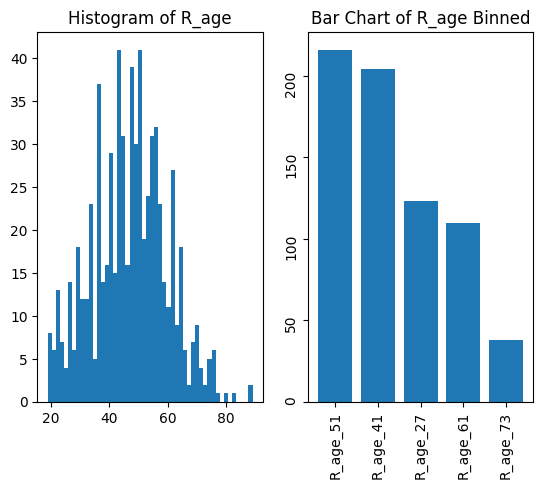

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['P_age_47' 'P_age_26' 'P_age_37' 'P_age_57' 'P_age_47' 'P_age_47'
 'P_age_68' 'P_age_47' 'P_age_37' 'P_age_47' 'P_age_47' 'P_age_47'
 'P_age_26' 'P_age_47' 'P_age_47' 'P_age_47' 'P_age_57' 'P_age_37'
 'P_age_37' 'P_age_37' 'P_age_57' 'P_age_37' 'P_age_37' 'P_age_47'
 'P_age_57' 'P_age_68' 'P_age_57' 'P_age_47' 'P_age_47' 'P_age_37'
 'P_age_26' 'P_age_68' 'P_age_37' 'P_age_47' 'P_age_26' 'P_age_26'
 'P_age_68' 'P_age_26' 'P_age_68' 'P_age_68' 'P_age_57' 'P_age_68'
 'P_age_47' 'P_age_37' 'P_age_37' 'P_age_47' 'P_age_47' 'P_age_47'
 'P_age_68' 'P_age_57' 'P_age_26' 'P_age_26' 'P_age_47' 'P_age_26'
 'P_age_68' 'P_age_37' 'P_age_47' 'P_age_37' 'P_age_57' 'P_age_47'
 'P_age_47' 'P_age_57' 'P_age_57' 'P_age_57' 'P_age_47' 'P_age_57'
 'P_age_47' 'P_age_68' 'P_age_57' 'P_age_47' 'P_age_57' 'P_age_37'
 'P_age_47'

<Figure size 640x480 with 0 Axes>

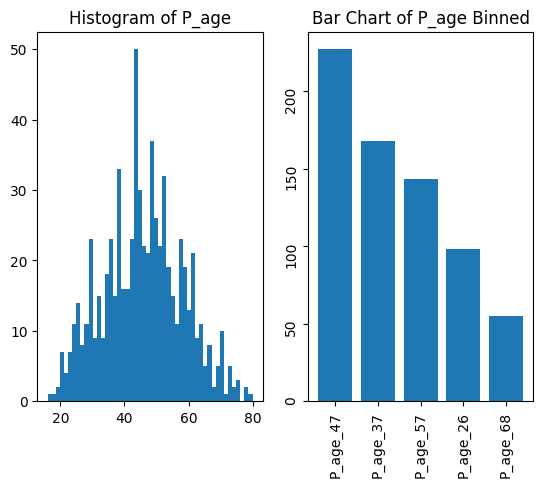

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['R_yrsed_15' 'R_yrsed_17' 'R_yrsed_12' 'R_yrsed_15' 'R_yrsed_17'
 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_20' 'R_yrsed_15' 'R_yrsed_17'
 'R_yrsed_15' 'R_yrsed_12' 'R_yrsed_20' 'R_yrsed_10' 'R_yrsed_17'
 'R_yrsed_12' 'R_yrsed_20' 'R_yrsed_15' 'R_yrsed_12' 'R_yrsed_15'
 'R_yrsed_15' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_17'
 'R_yrsed_15' 'R_yrsed_15' 'R_yrsed_15' 'R_yrsed_15' 'R_yrsed_15'
 'R_yrsed_17' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_15' 'R_yrsed_12'
 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_20' 'R_yrsed_17'
 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_15'
 'R_yrsed_15' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_12'
 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_12' 'R_yrsed_12'
 'R_yrsed_20' 'R_yrsed_12' 'R_yrsed_12' 'R_yrsed_17' 'R_yrsed_17'
 'R_yrsed_15' 'R_yrsed_

<Figure size 640x480 with 0 Axes>

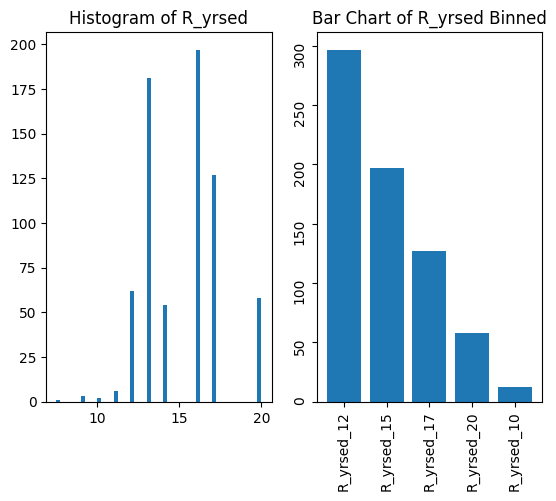

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['P_yrsed_12' 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_17' 'P_yrsed_17'
 'P_yrsed_16' 'P_yrsed_17' 'P_yrsed_17' 'P_yrsed_16' 'P_yrsed_12'
 'P_yrsed_16' 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_16' 'P_yrsed_12'
 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_16'
 'P_yrsed_17' 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_16' 'P_yrsed_17'
 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_16' 'P_yrsed_20'
 'P_yrsed_17' 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_16' 'P_yrsed_12'
 'P_yrsed_12' 'P_yrsed_20' 'P_yrsed_17' 'P_yrsed_12' 'P_yrsed_16'
 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_20' 'P_yrsed_12'
 'P_yrsed_17' 'P_yrsed_12' 'P_yrsed_17' 'P_yrsed_17' 'P_yrsed_16'
 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_16' 'P_yrsed_12' 'P_yrsed_17'
 'P_yrsed_17' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_12' 'P_yrsed_16'
 'P_yrsed_17' 'P_yrsed_

<Figure size 640x480 with 0 Axes>

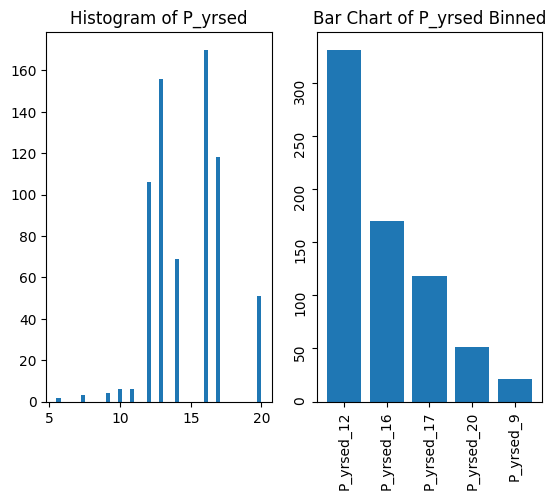

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['relationship_length_start_10' 'relationship_length_start_10'
 'relationship_length_start_10' 'relationship_length_start_10'
 'relationship_length_start_33' 'relationship_length_start_2'
 'relationship_length_start_33' 'relationship_length_start_10'
 'relationship_length_start_10' 'relationship_length_start_10'
 'relationship_length_start_2' 'relationship_length_start_20'
 'relationship_length_start_2' 'relationship_length_start_2'
 'relationship_length_start_10' 'relationship_length_start_2'
 'relationship_length_start_33' 'relationship_length_start_2'
 'relationship_length_start_2' 'relationship_length_start_10'
 'relationship_length_start_10' 'relationship_length_start_2'
 'relationship_length_start_2' 'relationship_length_start_20'
 'relationship_length_start_20' 'relationship_length_start_33'
 'rel

<Figure size 640x480 with 0 Axes>

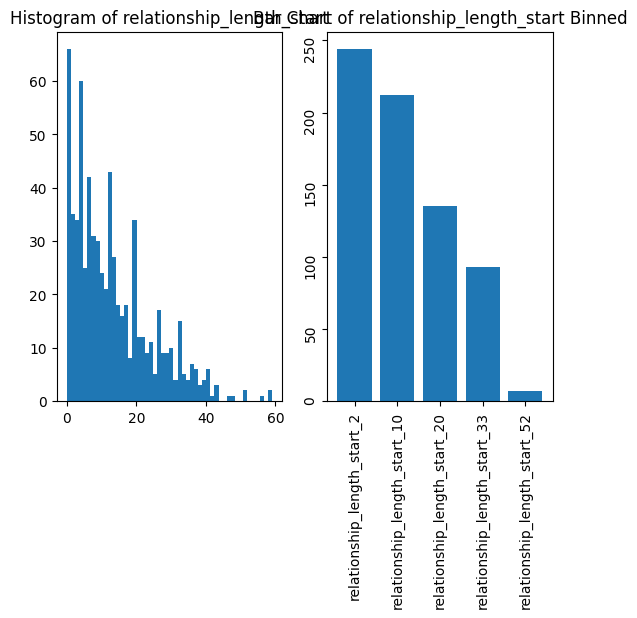

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['age_difference_1' 'age_difference_-4' 'age_difference_-4'
 'age_difference_-4' 'age_difference_9' 'age_difference_1'
 'age_difference_1' 'age_difference_9' 'age_difference_1'
 'age_difference_9' 'age_difference_1' 'age_difference_27'
 'age_difference_9' 'age_difference_-4' 'age_difference_-4'
 'age_difference_1' 'age_difference_9' 'age_difference_1'
 'age_difference_1' 'age_difference_27' 'age_difference_-4'
 'age_difference_1' 'age_difference_9' 'age_difference_9'
 'age_difference_9' 'age_difference_1' 'age_difference_9'
 'age_difference_1' 'age_difference_9' 'age_difference_1'
 'age_difference_1' 'age_difference_1' 'age_difference_9'
 'age_difference_-4' 'age_difference_9' 'age_difference_1'
 'age_difference_-4' 'age_difference_1' 'age_difference_1'
 'age_difference_-14' 'age_difference_-14' 'age_dif

<Figure size 640x480 with 0 Axes>

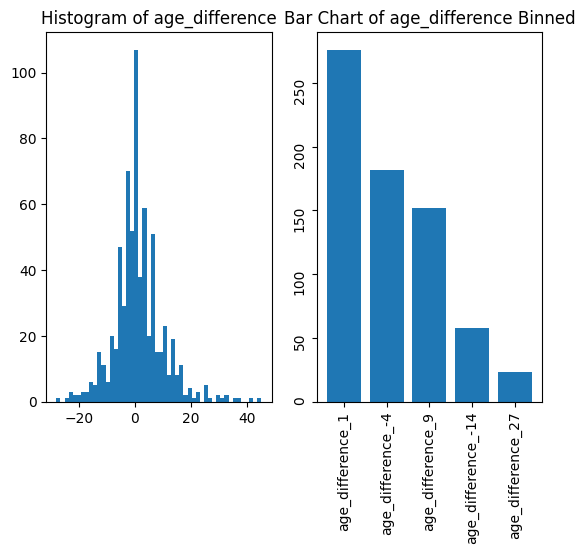

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_17848\407001903.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['edu_difference_2' 'edu_difference_0' 'edu_difference_2'
 'edu_difference_0' 'edu_difference_0' 'edu_difference_-3'
 'edu_difference_0' 'edu_difference_2' 'edu_difference_0'
 'edu_difference_5' 'edu_difference_0' 'edu_difference_-3'
 'edu_difference_5' 'edu_difference_-3' 'edu_difference_5'
 'edu_difference_0' 'edu_difference_5' 'edu_difference_2'
 'edu_difference_2' 'edu_difference_0' 'edu_difference_0'
 'edu_difference_-3' 'edu_difference_0' 'edu_difference_0'
 'edu_difference_0' 'edu_difference_0' 'edu_difference_2'
 'edu_difference_2' 'edu_difference_0' 'edu_difference_-3'
 'edu_difference_0' 'edu_difference_-3' 'edu_difference_0'
 'edu_difference_0' 'edu_difference_0' 'edu_difference_0'
 'edu_difference_-7' 'edu_difference_0' 'edu_difference_5'
 'edu_difference_0' 'edu_difference_-3' 'edu_differenc

<Figure size 640x480 with 0 Axes>

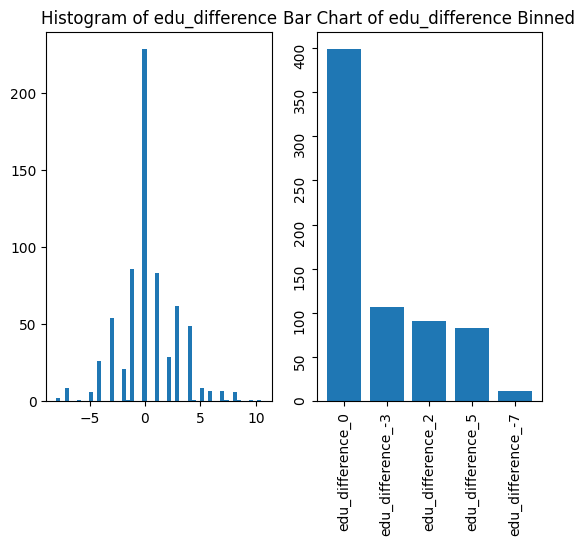

,R_race,P_race,R_political,P_political,R_religion,P_religion,R_work,R_house,R_rent,R_citydweller,...,union_status,broke_up,together_end,R_age_value,P_age_value,R_yrsed_value,P_yrsed_value,relationship_length_start_value,age_difference_value,edu_difference_value
0,Hispanic,NH white,democrat,democrat,catholic,"protestant (e.g. methodist, lutheran, presbyte...",working,a building with 2 or more apartments,rented for cash,metro,...,none,no,yes,R_age_51,P_age_47,R_yrsed_15,P_yrsed_12,relationship_length_start_10,age_difference_1,edu_difference_2
1,NH white,NH white,democrat,democrat,jewish,none,working,a building with 2 or more apartments,rented for cash,metro,...,married,no,yes,R_age_27,P_age_26,R_yrsed_17,P_yrsed_16,relationship_length_start_10,age_difference_-4,edu_difference_0
2,NH white,NH white,democrat,democrat,"other non-christian, please specify","other non-christian, please specify",working,a building with 2 or more apartments,owned or being bought by you or someone in you...,metro,...,none,w2,no,R_age_27,P_age_37,R_yrsed_12,P_yrsed_12,relationship_length_start_10,age_difference_-4,edu_difference_2
3,NH white,NH white,democrat,democrat,"protestant (e.g., methodist, lutheran, presbyt...",none,working,a one-family house detached from any other house,owned or being bought by you or someone in you...,metro,...,none,no,yes,R_age_51,P_age_57,R_yrsed_15,P_yrsed_17,relationship_length_start_10,age_difference_-4,edu_difference_0
4,NH white,NH white,democrat,democrat,"protestant (e.g., methodist, lutheran, presbyt...","protestant (e.g. methodist, lutheran, presbyte...",working,a building with 2 or more apartments,rented for cash,metro,...,married,no,yes,R_age_61,P_age_47,R_yrsed_17,P_yrsed_17,relationship_length_start_33,age_difference_9,edu_difference_0


<Figure size 640x480 with 0 Axes>

In [41]:
def get_knn_bins(df, cols, bins=5, drop_cols=True):
  
  for col in cols:
    
    kmeans  = KMeans(n_clusters=bins).fit(df[col].to_frame().values.reshape(-1,1))
    results = pd.DataFrame(kmeans.labels_, columns=[col + '_centroid'])

    df = df.reset_index()
    df[col + '_centroid'] = results[col + '_centroid']
  
    knn_bin_df = pd.DataFrame(kmeans.cluster_centers_)
    knn_bin_df = knn_bin_df.astype(int).reset_index()

    temp_df = pd.merge(df[col + '_centroid'],
                       knn_bin_df, 
                       left_on=col + '_centroid',
                       right_on='index',
                       how='left')
    
    # rename empty column header 0 -> column_name value
    temp_df = temp_df.rename(columns={0:col+'_value'})

    temp_df.loc[:,col+'_value'] = col + '_' + temp_df[col+'_value'].astype(str)

    df = pd.concat([df, temp_df[col+'_value']], axis=1)
    df.drop([col + '_centroid', 'index'], axis=1, inplace=True)


    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.hist(df[col].values, bins=50)
    ax1.set_title('Histogram of ' + col)

    # produce the second bar chart need the centroids and sort values to make bar chart
    # resemble the original distribution.
    Count_Bins = temp_df[col + '_value'].value_counts().rename_axis('bins').reset_index(name='counts')
    extract_number = Count_Bins.bins.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
    extract_number.columns = ['Text', 'Number']
    Count_Bins['bin_centroid'] = extract_number['Number']
    Count_Bins.sort_values(by=['bin_centroid'], ascending=True, inplace=True)

    ax2.bar(Count_Bins.iloc[:, 0], Count_Bins.iloc[:, 1])
    ax2.set_title('Bar Chart of ' + col + ' Binned')
    ax2.tick_params(labelrotation=90)

    plt.show()
    plt.tight_layout()


  if drop_cols:
    return df.drop(cols, axis=1)

  else:
    return df



recoded_df = get_knn_bins(data, numeric_cols, bins=5)
recoded_df.head()

In [43]:

def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [44]:
recoded_df.columns

Index(['R_race', 'P_race', 'R_political', 'P_political', 'R_religion',
       'P_religion', 'R_work', 'R_house', 'R_rent', 'R_citydweller',
       'R_region', 'same_sex_couple', 'relationship_quality', 'coresident',
       'rac_difference', 'pol_difference', 'relig_difference', 'LGB_status',
       'union_status', 'broke_up', 'together_end', 'R_age_value',
       'P_age_value', 'R_yrsed_value', 'P_yrsed_value',
       'relationship_length_start_value', 'age_difference_value',
       'edu_difference_value'],
      dtype='object')

In [46]:
var_selected = recoded_df[['age_difference_value',
                           'edu_difference_value',
                           'relationship_length_start_value',
                           'rac_difference',
                           'pol_difference',
                           'relig_difference',
                           'LGB_status',
                           'union_status',
                           'same_sex_couple',
                           'relationship_quality',
                           'coresident',
                           ]]

In [49]:
cat_cols = var_selected
categorical_indices = column_index(recoded_df, cat_cols.columns)
categorical = list(categorical_indices)


kmodes = KModes(verbose=0,
                n_clusters=4, 
                random_state=42)

kmodes_clusters = kmodes.fit_predict(recoded_df, categorical=categorical)

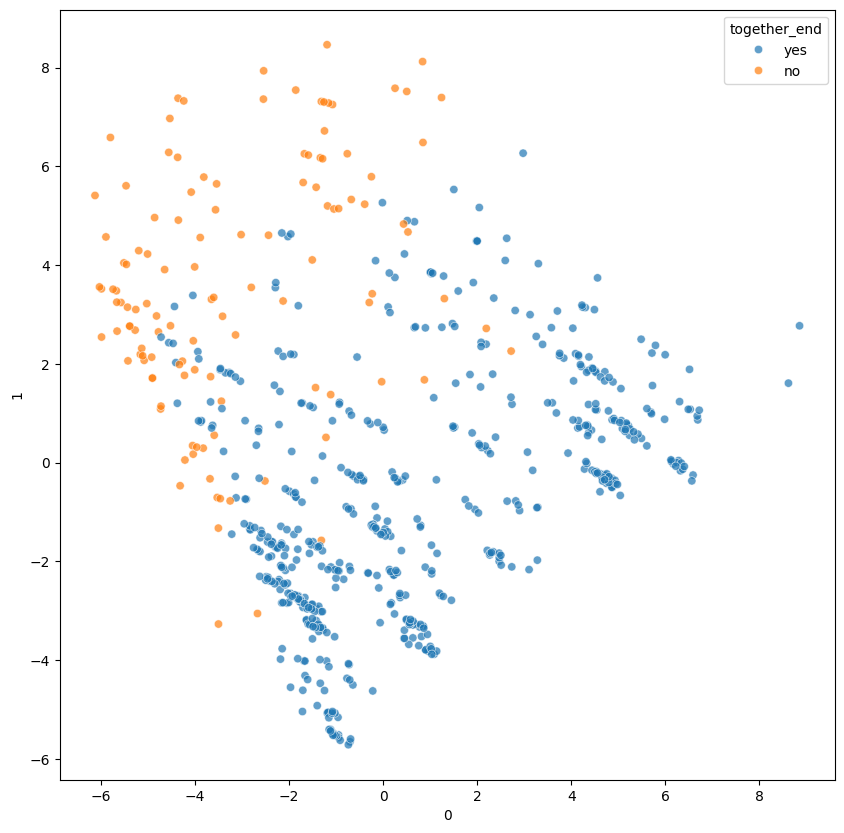

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
        data=data, 
        x=coords[0], 
        y=coords[1], 
        hue='together_end', 
        alpha=0.7, 
        ax=ax
    )

plt.show()

In [54]:
# use Umap to do embedding then cluster on that
def umap_embed(df, n_components=2, intersection=False):

  numerical = df.select_dtypes(exclude='object')

  for c in numerical.columns:
      numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)
      
  ##preprocessing categorical
  categorical = df.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)

  #Embedding numerical & categorical
  fit1 = umap.UMAP(random_state=12,
                   n_components=n_components).fit(numerical)
  
  fit2 = umap.UMAP(metric='dice', 
                   n_neighbors=250,
                   n_components=n_components).fit(categorical)


  # intersection will resemble the numerical embedding more.
  if intersection:
    embedding = fit1 * fit2

  # union will resemble the categorical embedding more.
  else:
    embedding = fit1 + fit2

  umap_embedding = embedding.embedding_

  
  return umap_embedding


embedding_ =  umap_embed(data, n_components=2, intersection=False)

AttributeError: module 'umap' has no attribute 'UMAP'

In [55]:
reducer = umap.UMAP(random_state=42)

AttributeError: module 'umap' has no attribute 'UMAP'